In [1]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

In [2]:
 #load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.python.keras.backend as K

'''
build a custom layer using Keras, integrating BERT from tf-hub,
we could also fine tune the BERT model, for example: only subset of pre-trained BERT layers
'''
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layer=12, bert_path='https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1', **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layer
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path, trainable=self.trainable, name="{}_module".format(self.name))
        trainable_vars = self.bert.variables
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers:]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        # Add non_trainable weights:
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs] #cast the variables to int32 tensor
        input_ids, input_mask, segment_ids, valid_positions = inputs
        ## we don't feed the valid_position into the model, the valid_position is only used for the slots transform to align to the tokenized input
        bert_inputs = dict(input_ids=input_ids, ## we can use 'convert_tokens_to_ids' function to get the ids from tokens
                           input_mask=input_mask,
                           segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature='tokens', as_dict=True)
        return result['pooled_output'], result['sequence_output']

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_size)


In [4]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

class NLUModel:

    def __init__(self):
        self.model = None

    def visualize_metric(self, history_dic, metric_name):
        plt.plot(history_dic[metric_name])
        legend = ['train']
        if 'val_' + metric_name in history_dic:
            plt.plot(history_dic['val_'+metric_name])
            legend.append('test')
        plt.title('model_' + metric_name)
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(legend, loc='upper left')
        plt.show()

    def predict(self, x):
        return self.model.predict(x)

    def save(self, model_path):
        self.model.save(model_path)

    def load(model_path, custom_objects=None):
        new_model = NLUModel()
        new_model.model = load_model(model_path, custom_objects=custom_objects)
        return new_model

    def predict_slots_intent(self, x, slots_tokenizer, intents_label_encoder):
        if len(x.shape) == 1:
            x = x[np.newaxis, ...]

        y1, y2 = self.predict(x)
        intents = np.array([intents_label_encoder.inverse_transform([np.argmax(y2[i])])[0] for i in range(y2.shape[0])])
        slots = []
        for i in range(y1.shape[0]):
            y = [np.argmax(i) for i in y1[i]]
            slot = []
            for i in y:
                if i == 0:
                    slot.append('o')
                else:
                    slot.append(slots_tokenizer.index_word[i])
            slots.append(slot[:len(x[i])+1])
        return intents, slots

In [5]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

'''
By using LabelEncoder to create the labelencoder of slot-tags
'''
class TagsVectorizer:

    def __init__(self):
        pass

    def tokenize(self, tags_str_arr):
        return [s.split() for s in tags_str_arr]

    def fit(self, train_tags_str_arr, val_tags_str_arr):
        ## in order to avoid, in valid_dataset, there is tags which not exit in train_dataset. like: ATIS datset
        self.label_encoder = LabelEncoder()
        data = ["[padding]", "[CLS]", "[SEP]"] + [item for sublist in self.tokenize(train_tags_str_arr) for item in sublist]
        data = data + [item for sublist in self.tokenize(val_tags_str_arr) for item in sublist]
        ## # data:  ["[padding]", "[CLS]", "[SEP]", all of the real tags]; add the "[padding]", "[CLS]", "[SEP]" for the real tag list
        self.label_encoder.fit(data)

    def transform(self, tags_str_arr, valid_positions):
        ## if we set the maximum length is 50, then the seq_length is 50; otherwise, it will be equal to the maximal length of dataset
        seq_length = valid_positions.shape[1] # .shape[0]: number of rows, .shape[1]: number of columns
        data = self.tokenize(tags_str_arr)
        ## we added the 'CLS' and 'SEP' token as the first and last token for every sentence respectively
        data = [self.label_encoder.transform(["[CLS]"] + x + ["[SEP]"]).astype(np.int32) for x in data] #upper 'O', not 0

        output = np.zeros((len(data), seq_length))
        for i in range(len(data)):
            idx = 0
            for j in range(seq_length):
                if valid_positions[i][j] == 1:
                    output[i][j] = data[i][idx]
                    idx += 1
        return output

    def inverse_transform(self, model_output_3d, valid_position):
        ## model_output_3d is the predicted slots output of trained model
        seq_length = valid_position.shape[1]
        slots = np.argmax(model_output_3d, axis=-1)
        slots = [self.label_encoder.inverse_transform(y) for y in slots]
        output = []
        for i in range(len(slots)):
            y = []
            for j in range(seq_length):
                if valid_position[i][j] == 1: ## only valid_positions = 1 have the real slot-tag
                    y.append(str(slots[i][j]))
            output.append(y)
        return output

    def load(self):
        pass

    def save(self):
        pass

if __name__ == '__main__':
    train_tags_str_arr = ['O O B-X B-Y', 'O B-Y O']
    val_tags_str_arr = ['O O B-X B-Y', 'O B-Y O XXX']
    valid_positions = np.array([[1, 1, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0, 1]])

    vectorizer = TagsVectorizer()
    vectorizer.fit(train_tags_str_arr, val_tags_str_arr)
    data = vectorizer.transform(train_tags_str_arr, valid_positions)
    print(data, vectorizer.label_encoder.classes_)

[[4. 2. 2. 0. 0. 1. 5.]
 [4. 2. 0. 1. 2. 0. 5.]] ['B-X' 'B-Y' 'O' 'XXX' '[CLS]' '[SEP]' '[padding]']


In [6]:
!pip install bert-tensorflow

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from bert.tokenization import FullTokenizer

'''
import the BERT model from tensorflow_hub library and create the tokenizer to pre-process the dataset,
and to tokenize every word and get the corresponding input_ids, input_mask, segment_ids and valid_positions of every sentence
'''
class BERTVectorizer:

    def __init__(self, sess, bert_model_hub_path):
        self.sess = sess
        self.bert_model_hub_path = bert_model_hub_path
        self.create_tokenizer_from_hub_module()
        print(bert_model_hub_path)

    def create_tokenizer_from_hub_module(self):
        # get the vocabulary and lowercasing or uppercase information directly from the BERT tf hub module
        bert_module = hub.Module(self.bert_model_hub_path)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = self.sess.run(
            [
                tokenization_info["vocab_file"],
                tokenization_info["do_lower_case"]
            ]
        )
        self.tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case) #do_lower_case=True
        # print(tokenizer.tokenize('hello world!'))  --> ['hello', 'world', '!']

    def tokenize(self, text:str): ## tokenize every sentence
        words = text.split()
        ## # text: add leah kauffman to my uncharted 4 nathan drake playlist
        ## # words: ['add', 'leah', 'kauffman', 'to', 'my', 'uncharted', '4', 'nathan', 'drake', 'playlist']
        tokens = []
        ## # tokens: ['add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list']
        valid_positions = []
        ## # valid_positions:[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
        for i, word in enumerate(words):
            token = self.tokenizer.tokenize(word)
            tokens.extend(token)
            for i in range(len(token)):
                if i == 0:
                    valid_positions.append(1)
                else:
                    valid_positions.append(0)
        
        return tokens, valid_positions

    def transform(self, text_arr):
        input_ids = []
        input_mask = []
        segment_ids = []
        valid_positions = []
        for text in text_arr:
            ids, mask, seg_ids, valid_pos = self.__vectorize(text)
            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)
            valid_positions.append(valid_pos)

        sequence_length = np.array([len(i) for i in input_ids])

        ## set the maximum length is 50
        input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=50, truncating='post', padding='post')
        input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=50, truncating='post', padding='post')
        segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=50, truncating='post', padding='post')
        valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, maxlen=50, truncating='post', padding='post')

        # input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
        # input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, padding='post')
        # segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, padding='post')
        # valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, padding='post')

        return input_ids, input_mask, segment_ids, valid_positions, sequence_length

    def __vectorize(self, text:str):
        tokens, valid_positions = self.tokenize(text)

        ## insert the first token "[CLS]"
        tokens.insert(0, '[CLS]')
        valid_positions.insert(0, 1)
        ## insert the last token "[SEP]"
        tokens.append('[SEP]')
        valid_positions.append(1)
        ## ['[CLS]', 'add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list', '[SEP]']
        ## [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

        '''
        (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0     0   0   0  0     0 0
        
        Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        '''
        segment_ids = [0] * len(tokens)
        ## # segment_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        ## # input_ids: [101, 5587, 14188, 10556, 16093, 16715, 2319, 2000, 2026, 4895, 7507, 17724, 1018, 7150, 7867, 2377, 9863, 102] and the first is always 101 and the last is 102

        input_mask = [1] * len(input_ids) ## The mask has 1 for real tokens and 0 for padding tokens.
        ## # input_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

        return input_ids, input_mask, segment_ids, valid_positions

In [8]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Multiply, TimeDistributed, Dropout
import numpy as np
import os
import json

'''
build and compile our model using the BERT layer
'''
class JointBertModel(NLUModel):
    def __init__(self, slots_num, intents_num, sess, num_bert_fine_tune_layers=12):
        self.slots_num = slots_num
        self.intents_num = intents_num
        self.num_bert_fine_tune_layers = num_bert_fine_tune_layers

        self.model_params = {
            'slots_num': slots_num,
            'intents_num': intents_num,
            'num_bert_fine_tune_layers': num_bert_fine_tune_layers
        }

        self.build_model()
        self.compile_model()

        self.initialize_vars(sess)


    def build_model(self):

        in_id = Input(shape=(None,), name='input_ids')
        in_mask = Input(shape=(None,), name='input_masks')
        in_segment = Input(shape=(None,), name='segment_ids')
        in_valid_positions = Input(shape=(None, self.slots_num), name='valid_positions')
        bert_inputs = [in_id, in_mask, in_segment, in_valid_positions]

        # the output of trained Bert
        bert_pooled_output, bert_sequence_output = BertLayer(n_fine_tune_layer=self.num_bert_fine_tune_layers, name='BertLayer')(bert_inputs)

        # add the additional layer for intent classification and slot filling
        intents_drop = Dropout(rate=0.1)(bert_pooled_output)
        intents_fc = Dense(self.intents_num, activation='softmax', name='intent_classifier')(intents_drop)

        slots_drop = Dropout(rate=0.1)(bert_sequence_output)
        slots_output = TimeDistributed(Dense(self.slots_num, activation='softmax'))(slots_drop)
        slots_output = Multiply(name='slots_tagger')([slots_output, in_valid_positions])

        self.model = Model(inputs=bert_inputs, outputs=[slots_output, intents_fc])

    def compile_model(self):
        optimizer = tf.keras.optimizers.Adam(lr=5e-5)
        # if the targets are one-hot labels, using 'categorical_crossentropy'; while if targets are integers, using 'sparse_categorical_crossentropy'
        losses = {
            'slots_tagger': 'sparse_categorical_crossentropy',
            'intent_classifier': 'sparse_categorical_crossentropy'
        }
        ## loss_weights: to weight the loss contributions of different model outputs.
        loss_weights = {'slots_tagger': 3.0, 'intent_classifier': 1.0}
        metrics = {'intent_classifier': 'acc'}
        self.model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=metrics)
        self.model.summary()

    def fit(self, X, Y, validation_data=None, epochs=5, batch_size=32):
        X = (X[0], X[1], X[2], self.prepare_valid_positions(X[3]))
        if validation_data is not None:
            X_val, Y_val = validation_data
            validation_data = ((X_val[0], X_val[1], X_val[2], self.prepare_valid_positions(X_val[3])), Y_val)

        history = self.model.fit(X, Y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)

        self.visualize_metric(history.history, 'slots_tagger_loss')
        self.visualize_metric(history.history, 'intent_classifier_loss')
        self.visualize_metric(history.history, 'loss')
        self.visualize_metric(history.history, 'intent_classifier_acc')


    def prepare_valid_positions(self, in_valid_positions):
        ## the input is 2-D in_valid_position
        in_valid_positions = np.expand_dims(in_valid_positions, axis=2) ## expand the shape of the array to axis=2
        ## 3-D in_valid_position
        in_valid_positions = np.tile(in_valid_positions, (1,1,self.slots_num)) ##
        return in_valid_positions

    def predict_slots_intent(self, x, slots_vectorizer, intent_vectorizer, remove_start_end=True):
        valid_positions = x[3]
        x = (x[0], x[1], x[2], self.prepare_valid_positions(valid_positions))

        y_slots, y_intent = self.predict(x)

        ### get the real slot-tags using 'inverse_transform' of slots-vectorizer
        slots = slots_vectorizer.inverse_transform(y_slots, valid_positions)
        if remove_start_end: ## remove the first '[CLS]' and the last '[SEP]' tokens.
            slots = np.array([x[1:-1] for x in slots])

        ### get the real intents using 'inverse-transform' of intents-vectorizer
        intents = np.array([intent_vectorizer.inverse_transform([np.argmax(y_intent[i])])[0] for i in range(y_intent.shape[0])])
        return slots, intents

    def initialize_vars(self, sess):
        sess.run(tf.compat.v1.local_variables_initializer())
        sess.run(tf.compat.v1.global_variables_initializer())
        K.set_session(sess)

    def save(self, model_path):
        with open(os.path.join(model_path, 'params.json'), 'w') as json_file:
            json.dump(self.model_params, json_file)
        self.model.save_weights(os.path.join(model_path, 'joint_bert_model.h5'))

    def load(load_folder_path, sess):
        with open(os.path.join(load_folder_path, 'params.json'), 'r') as json_file:
            model_params = json.load(json_file)

        slots_num = model_params['slots_num']
        intents_num = model_params['intents_num']
        num_bert_fine_tune_layers = model_params['num_bert_fine_tune_layers']

        new_model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers)
        new_model.model.load_weights(os.path.join(load_folder_path, 'joint_bert_model.h5'))
        return new_model


In [9]:
import os

class Reader:
    def __init__(self):
        pass

    def read(dataset_folder_path):
        labels = None
        text_arr = None
        tags_arr = None

        with open(os.path.join(dataset_folder_path, 'label'), encoding='utf-8') as f:
            labels = f.readlines()

        with open(os.path.join(dataset_folder_path, 'seq.in'), encoding='utf-8') as f:
            text_arr = f.readlines()

        with open(os.path.join(dataset_folder_path, 'seq.out'), encoding='utf-8') as f:
            tags_arr = f.readlines()

        assert len(text_arr) == len(tags_arr) == len(labels) # test by using 'assert'
        for i in range(len(text_arr)-1):
          text_arr[i+1]=text_arr[i+1]+' '
          text_arr[i+1]=text_arr[i+1]+labels[i]
          tags_arr[i+1]=tags_arr[i+1]+' O'
        return text_arr, tags_arr, labels

if __name__ == '__main__':
    text_arr, tags_arr, labels = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/snips/valid')
    print(text_arr, tags_arr, labels)

['i d like to have this track onto my classical relaxations playlist \n', 'add the album to my flow español playlist \n AddToPlaylist\n', 'add digging now to my young at heart playlist\n AddToPlaylist\n', 'add this song by too poetic to my piano ballads playlist\n AddToPlaylist\n', 'add this album to old school death metal\n AddToPlaylist\n', 'i need to add baro ferret to the urban hits under my name\n AddToPlaylist\n', 'add the album to the might and myth power metal playlist \n AddToPlaylist\n', 'to the travelling playlist  please add this david gahan song \n AddToPlaylist\n', 'please add some pete townshend to my playlist fiesta hits con lali\n AddToPlaylist\n', 'i d like for kasey chambers s tune to be an addition to my chips and salsa playlist \n AddToPlaylist\n', 'add recalled to life to this is alejandro fernández\n AddToPlaylist\n', 'add nuba to my metal party playlist\n AddToPlaylist\n', 'add jo stafford music to the workout twerkout playlist\n AddToPlaylist\n', 'put jean phil

In [10]:
print(len(text_arr),len(tags_arr),len(labels))

700 700 700


In [11]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

16
['listen to westbam alumb allergic on google music\n', 'add step to me to the 50 clásicos playlist \n PlayMusic\n', 'i give this current textbook a rating value of 1 and a best rating of 6\n AddToPlaylist\n', 'play the song little robin redbreast\n RateBook\n', 'please add iris dement to my playlist this is selena\n PlayMusic\n', 'add slimm cutta calhoun to my this is prince playlist  \n AddToPlaylist\n', 'i want to listen to seventies music \n AddToPlaylist\n', 'play a popular chant by brian epstein\n PlayMusic\n', 'find fish story \n PlayMusic\n', 'book a spot for 3 in mt\n SearchScreeningEvent\n', 'i need a forecast for jetmore  massachusetts in 1 hour and 1 second from now\n BookRestaurant\n', 'rate this series a 5\n GetWeather\n', 'give me a list of movie times for films in the area \n RateBook\n', 'can you play me some eighties music by adele\n SearchScreeningEvent\n', 'please let me know the weather forcast of stanislaus national forest far in nine months\n PlayMusic\n', 'boo

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
7
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 75)]   0                                            
______________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 13084 samples, validate on 700 samples
Epoch 1/16
13084/13084 [==============================] - 119s 9ms/sample - loss: 11.7192 - slots_tagger_loss: 3.7258 - intent_classifier_loss: 0.5384 - intent_classifier_acc: 0.8248 - val_loss: 10.5073 - val_slots_tagger_loss: 3.4787 - val_intent_classifier_loss: 0.0712 - val_intent_classifier_acc: 0.9857
Epoch 2/16
13084/13084 [==============================] - 117s 9ms/sample - loss: 10.3759 - slots_tagger_loss: 3.4364 - intent_classifier_loss: 0.0666 - intent_classifier_acc: 0.9816 - val_loss: 10.1940 - val_slots_tagger_loss: 3.3826 - val_intent_classifier_loss: 0.0461 - val_intent_classifier_acc: 0.9857
Epoch 3/16
13084/13084 [==============================] - 117s 9ms/sample - loss: 10.1619 - slots_tagger_loss: 3.3748 - intent_classifier_loss: 0.0371 - intent_classifier_acc: 0.9894 - val_loss: 10.1233 - val_slots_tagger_loss: 3.3486 - val_intent_classifier_loss: 0.0776 - val_intent_classifier_acc: 0.9771
Epoch 4/16
13084/13084 [====

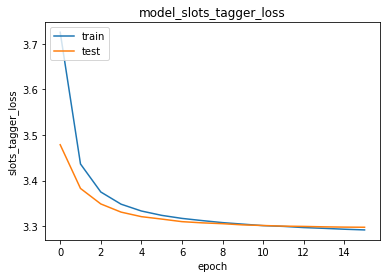

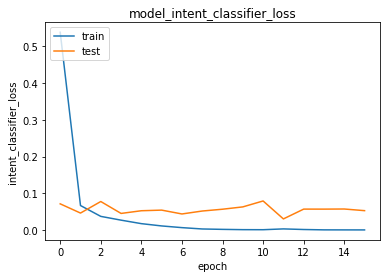

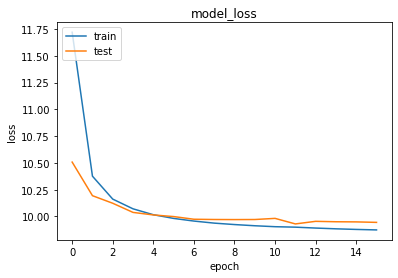

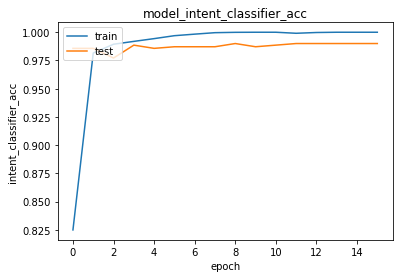

saving...
save


In [12]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import argparse
import tensorflow as tf
import pickle
import os

parser = argparse.ArgumentParser('Training the Joint Slot filling and Intent classification based on Bert')
parser.add_argument('--train', '-t', help='path to training data', type=str, required=True)
parser.add_argument('--val', '-v', help='path to validation data', type=str, required=True)
parser.add_argument('--save', '-s', help='folder path to save the trained model', type=str, required=True)
parser.add_argument('--epochs', '-e', help='number of epochs', type=int, default=5, required=False)
parser.add_argument('--batch_size', '-bs', help='batch size', type=int, default=64, required=False)

args = parser.parse_args('-t train -v val -s save'.split() )
train_data_folder_path =args.train
val_data_folder_path =args.val
save_folder_path =args.save
epochs =16
print(epochs)
batch_size =64

tf.compat.v1.random.set_random_seed(7)

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'

## import the dataset
train_text_arr, train_tags_arr, train_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/snips/train') ## train dataset
val_text_arr, val_tags_arr, val_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/snips/valid') ## validation dataset
print(train_text_arr)
# vectorize the train_text_arr and val_text_arr
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)
train_input_ids, train_input_mask, train_segment_ids, train_valid_positions, train_sequence_lengths = bert_vectorizer.transform(train_text_arr)
val_input_ids, val_input_mask, val_segment_ids, val_valid_positions, val_sequence_lengths = bert_vectorizer.transform(val_text_arr)

## vectorize the train_tags_arr and val_tags_arr
tags_vectorizer = TagsVectorizer()
tags_vectorizer.fit(train_tags_arr, val_tags_arr) ## use the train dataset to fit the tagsvectorizer
train_tags = tags_vectorizer.transform(train_tags_arr, train_valid_positions)
val_tags = tags_vectorizer.transform(val_tags_arr, val_valid_positions)
slots_num = len(tags_vectorizer.label_encoder.classes_)


## encode the intents label, directly by using the LabelEncoder library, which is provided by skeleran
intents_label_encoder = LabelEncoder()
### atis dataset is a little strange, because in val_dataset, there are tags and intents that don't exit in train_dataset
intents_label_encoder.fit(train_intents+val_intents)
train_intents = intents_label_encoder.transform(train_intents).astype(np.int64)

# ## we should use the train dataset to fit the label encoder and then return the encoded labels
# train_intents = intents_label_encoder.fit_transform(train_intents).astype(np.int32) ## fit_transform

val_intents = intents_label_encoder.transform(val_intents).astype(np.int64) ## transform
intents_num = len(intents_label_encoder.classes_)
print(intents_num)

model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers=12)
model.fit([train_input_ids, train_input_mask, train_segment_ids, train_valid_positions], [train_tags, train_intents],
          validation_data=([val_input_ids, val_input_mask, val_segment_ids, val_valid_positions], [val_tags, val_intents]),
          epochs=epochs, batch_size=batch_size)

## saving
print('saving...')
print(save_folder_path)
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)
    print('Folder "%s" created' % save_folder_path)
model.save(save_folder_path)

with open(os.path.join(save_folder_path, 'tags_vectorizer.pkl'), 'wb') as handle:
    pickle.dump(tags_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(save_folder_path, 'intents_label_encoder.pkl'), 'wb') as handle:
    pickle.dump(intents_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

tf.compat.v1.reset_default_graph()

In [13]:
print(train_tags)

[[72. 71. 71. ...  0.  0.  0.]
 [72. 71.  9. ...  0.  0.  0.]
 [72. 71. 71. ...  0.  0.  0.]
 ...
 [72. 71. 71. ...  0.  0.  0.]
 [72. 71. 71. ...  0.  0.  0.]
 [72. 71. 18. ...  0.  0.  0.]]


In [14]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =128
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/save'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/save', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
    print(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/save', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
    print(intents_label_encoder.classes_)
model = JointBertModel.load('/content/save', sess)

data_text_arr, data_tags_arr, data_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/snips/test')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)


def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]

    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score, acc, predicted_intents, predicted_tags


print('.....Evaluation....')
f1_score, acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,
                            data_tags_arr, data_intents, tags_vectorizer, intents_label_encoder)


### print(type(predicted_tags)) ## <class 'numpy.ndarray'>
### save the predicted slots to file
with open(os.path.join('/content/save', pre_slots_name), 'w') as fp:
    for item in predicted_tags:
        #print(item)
        fp.write(" ".join(item) + "\n")
    fp.close()

### print(type(predicted_intents)) ## <class 'numpy.ndarray'>
### save the predicted intents to file
with open(os.path.join('/content/save', pre_intens_name), 'w') as fp:
    for item in predicted_intents:
        #print(item)
        fp.write("".join(map(str, item)))
    fp.close()

print('Slot f1 score = %f' % f1_score)
print('Intent accuracy = %f' % acc)


### save the f1 score and accuracy to file
eva_results = {
    "slots_f1_score" : f1_score,
    "intent_accuracy" : acc
}
with open(os.path.join('/content/save', "eva_results.json"), 'w') as json_file:
    json.dump(eva_results, json_file)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
Loading models ....
['B-album' 'B-artist' 'B-best_rating' 'B-city' 'B-condition_description'
 'B-condition_temperature' 'B-country' 'B-cuisine' 'B-current_location'
 'B-entity_name' 'B-facility' 'B-genre' 'B-geographic_poi'
 'B-location_name' 'B-movie_name' 'B-movie_type' 'B-music_item'
 'B-object_location_type' 'B-object_name' 'B-object_part_of_series_type'
 'B-object_select' 'B-object_type' 'B-party_size_description'
 'B-party_size_number' 'B-playlist' 'B-playlist_owner' 'B-poi'
 'B-rating_unit' 'B-rating_value' 'B-restaurant_name' 'B-restaurant_type'
 'B-served_dish' 'B-service' 'B-sort' 'B-spatial_relation' 'B-state'
 'B-timeRange' 'B-track' 'B-year' 'I-album' 'I-artist' 'I-city'
 'I-country' 'I-cuisine' 'I-current_location' 'I-entity_name' 'I-facility'
 'I-genre' 'I-geographic_poi' 'I-location_name' 'I-movie_name'
 'I-movie_type' 'I-music_item' 'I-object_location_type' 'I-object_name'
 'I-object_part_of_series_type' 'I-object

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 75)]   0                                            
______________________________________________________________________________________________

In [15]:
print(data_text_arr[0])
print(predicted_intents[0])
print(data_tags_arr[0])
print(data_intents[0])
print(predicted_tags[0])

add sabrina salerno to the grime instrumentals playlist

AddToPlaylist

O B-artist I-artist O O B-playlist I-playlist O 

AddToPlaylist

['O', 'B-artist', 'I-artist', 'O', 'O', 'B-playlist', 'I-playlist', 'O']


In [16]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print ('Confusion Matrix :')
results = confusion_matrix(data_intents, predicted_intents) 
print(results) 
print ('Accuracy Score :',accuracy_score(data_intents, predicted_intents) )
print ('Report : ')
print (classification_report(data_intents, predicted_intents) )

Confusion Matrix :
[[124   0   0   0   0   0   0]
 [  0  92   0   0   0   0   0]
 [  0   2 102   0   0   0   0]
 [  1   0   0  82   1   2   0]
 [  0   0   0   0  80   0   0]
 [  0   0   0   2   0 104   1]
 [  0   0   0   0   0   9  98]]
Accuracy Score : 0.9742857142857143
Report : 
                       precision    recall  f1-score   support

       AddToPlaylist
       0.99      1.00      1.00       124
      BookRestaurant
       0.98      1.00      0.99        92
          GetWeather
       1.00      0.98      0.99       104
           PlayMusic
       0.98      0.95      0.96        86
            RateBook
       0.99      1.00      0.99        80
  SearchCreativeWork
       0.90      0.97      0.94       107
SearchScreeningEvent
       0.99      0.92      0.95       107

             accuracy                           0.97       700
            macro avg       0.98      0.97      0.97       700
         weighted avg       0.98      0.97      0.97       700



In [17]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =128
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/save'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/save', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
    print(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/save', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
    print(intents_label_encoder.classes_)
model = JointBertModel.load('/content/save', sess)

data_text_arr, data_tags_arr, data_intents = Reader.read('/content/drive/My Drive/iit patna internship NLU_Code/joint-intent-classification-and-slot-filling-based-on-BERT/data/snips/valid')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)


def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]

    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score, acc, predicted_intents, predicted_tags


print('.....Evaluation....')
f1_score, acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,
                            data_tags_arr, data_intents, tags_vectorizer, intents_label_encoder)


### print(type(predicted_tags)) ## <class 'numpy.ndarray'>
### save the predicted slots to file
with open(os.path.join('/content/save', pre_slots_name), 'w') as fp:
    for item in predicted_tags:
        #print(item)
        fp.write(" ".join(item) + "\n")
    fp.close()

### print(type(predicted_intents)) ## <class 'numpy.ndarray'>
### save the predicted intents to file
with open(os.path.join('/content/save', pre_intens_name), 'w') as fp:
    for item in predicted_intents:
        #print(item)
        fp.write("".join(map(str, item)))
    fp.close()

print('Slot f1 score = %f' % f1_score)
print('Intent accuracy = %f' % acc)


### save the f1 score and accuracy to file
eva_results = {
    "slots_f1_score" : f1_score,
    "intent_accuracy" : acc
}
with open(os.path.join('/content/save', "eva_results.json"), 'w') as json_file:
    json.dump(eva_results, json_file)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1
Loading models ....
['B-album' 'B-artist' 'B-best_rating' 'B-city' 'B-condition_description'
 'B-condition_temperature' 'B-country' 'B-cuisine' 'B-current_location'
 'B-entity_name' 'B-facility' 'B-genre' 'B-geographic_poi'
 'B-location_name' 'B-movie_name' 'B-movie_type' 'B-music_item'
 'B-object_location_type' 'B-object_name' 'B-object_part_of_series_type'
 'B-object_select' 'B-object_type' 'B-party_size_description'
 'B-party_size_number' 'B-playlist' 'B-playlist_owner' 'B-poi'
 'B-rating_unit' 'B-rating_value' 'B-restaurant_name' 'B-restaurant_type'
 'B-served_dish' 'B-service' 'B-sort' 'B-spatial_relation' 'B-state'
 'B-timeRange' 'B-track' 'B-year' 'I-album' 'I-artist' 'I-city'
 'I-country' 'I-cuisine' 'I-current_location' 'I-entity_name' 'I-facility'
 'I-genre' 'I-geographic_poi' 'I-location_name' 'I-movie_name'
 'I-movie_type' 'I-music_item' 'I-object_location_type' 'I-object_name'
 'I-object_part_of_series_type' 'I-object

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 75)]   0                                            
______________________________________________________________________________________________

In [18]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print ('Confusion Matrix :')
results = confusion_matrix(data_intents, predicted_intents) 
print(results) 
print ('Accuracy Score :',accuracy_score(data_intents, predicted_intents) )
print ('Report : ')
print (classification_report(data_intents, predicted_intents) )

Confusion Matrix :
[[100   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0]
 [  0   0  99   0   0   0   1]
 [  0   1   0  99   0   0   0]
 [  0   0   0   0 100   0   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0   5  95]]
Accuracy Score : 0.99
Report : 
                       precision    recall  f1-score   support

       AddToPlaylist
       1.00      1.00      1.00       100
      BookRestaurant
       0.99      1.00      1.00       100
          GetWeather
       1.00      0.99      0.99       100
           PlayMusic
       1.00      0.99      0.99       100
            RateBook
       1.00      1.00      1.00       100
  SearchCreativeWork
       0.95      1.00      0.98       100
SearchScreeningEvent
       0.99      0.95      0.97       100

             accuracy                           0.99       700
            macro avg       0.99      0.99      0.99       700
         weighted avg       0.99      0.99      0.99       700

